In [92]:
import os
import pandas as pd
import numpy as np
import pathlib
import pickle
import matplotlib.pyplot as plt
import copy
project_path = '/Users/zhangxun/data/robust_scheduling/det_release/processing_variance/'

# impact of c

In [93]:
n = 20 # num of jobs
delta_mu = 4 # control lb of mean processing time
delta_r = 0.1 # control ub of the release time
delta_ep = 1.5 # control the upper bound of the mad
S_train = 20
S_test = 10000
iterations = 1
instances = 20
range_c = np.arange(0,1,0.1)

In [94]:
def load_results(ins,n,iterations,project_path,file_name):
    rst_mean = np.zeros(iterations)
    rst_75 = np.zeros(iterations)
    rst_95 = np.zeros(iterations)
    for it in range(iterations):
        full_path = project_path + 'ins='+str(ins)+'/' + 'n='+str(n)+'/' + 'iteration='+str(it)+'/'
        # print(full_path)
        # deterministic results
        with open(full_path+file_name, "rb") as tf:
            sol = pickle.load(tf)
        rst_mean[it] = np.mean(sol['out_obj'])
        rst_75[it] = np.quantile(sol['out_obj'],0.75)
        rst_95[it] = np.quantile(sol['out_obj'],0.95)
    rst = {}
    rst['avg'] = rst_mean
    rst['quan_75'] = rst_75
    rst['quan_95'] = rst_95
    return rst


In [95]:
def load_wass_results(ins,n,iterations,range_c,project_path,file_name):
    len_c = len(range_c)
    avg = np.zeros((iterations,len_c))
    quan75 = np.zeros((iterations,len_c))
    quan95 = np.zeros((iterations,len_c))
    for it in range(iterations):
        full_path = project_path + 'ins='+str(ins)+'/' + 'n='+str(n)+'/' + 'iteration='+str(it)+'/'
        # print(full_path)
        # deterministic results
        with open(full_path+file_name, "rb") as tf:
            sol = pickle.load(tf)
        avg[it,:] = np.asarray(sol['out_obj'].mean(axis=0))
        quan75[it,:] = np.asarray(sol['out_obj'].quantile(axis = 0,q = 0.75))
        quan95[it,:] = np.asarray(sol['out_obj'].quantile(axis = 0,q = 0.95))
    rst = {}
    rst['avg'] = avg
    rst['quan_75'] = quan75
    rst['quan_95'] = quan95
    return rst

# Impact of processing time variance

In [111]:
file_name = project_path + 'delta_ep=' 
def obtain_results(n,delta_all,name,file_name):
    rst_det = np.zeros((len(delta_all),instances))
    rst_saa = np.zeros((len(delta_all),instances))
    rst_mom = np.zeros((len(delta_all),instances))
    # rst_wass_exact = {}
    rst_wass_vns = {}
    for i in range(len(delta_all)):
        delta = delta_all[i]
        # print('delta_ep=',delta_ep,'-----------------------')
        file_path1 = file_name+str(delta) + '/'
        rst_wass_vns_arr = np.zeros((instances,len(range_c)))
        for ins in range(instances):
            rst_det[i,ins] = load_results(ins,n,iterations,file_path1,'sol_det.pkl')[name]
            rst_saa[i,ins] = load_results(ins,n,iterations,file_path1,'sol_saa.pkl')[name]
            rst_mom[i,ins] = load_results(ins,n,iterations,file_path1,'sol_mom.pkl')[name]
            # rst_wass_exact[n] = load_wass_results(n,iterations,range_c,project_path,'sol_wass_exact.pkl.pkl')
            rst_wass_vns_arr[ins,:] = load_wass_results(ins,n,iterations,range_c,file_path1,'sol_wass_vns.pkl')[name]
        rst_wass_vns[delta] = rst_wass_vns_arr
    return rst_det,rst_saa,rst_mom,rst_wass_vns

In [116]:
def obtain_mean_rst(rst_det,rst_saa,rst_mom,rst_wass_vns,delta_all):
    rst_det_avg = np.mean(rst_det,axis = 1)
    rst_wass = np.zeros((len(delta_all),len(range_c)))
    for i in range(len(delta_all)):
        delta_ep = delta_all[i]
        rst_wass[i,:] = np.mean(rst_wass_vns[delta_ep],axis = 0)/rst_det_avg[i]
    rst = pd.DataFrame(data=rst_wass,columns=range_c)
    rst['saa'] = np.mean(rst_saa,axis = 1)/rst_det_avg
    rst['mom'] = np.mean(rst_mom,axis = 1)/rst_det_avg
    rst['det'] = rst_det_avg
    return rst

In [106]:
delta_ep_all = np.arange(0.2,2.1,0.2)
n = 20
# average performance
name = 'avg'
rst_det,rst_saa,rst_mom,rst_wass_vns = obtain_results(n,delta_ep_all,name)
rst_avg = obtain_mean_rst(rst_det,rst_saa,rst_mom,rst_wass_vns,delta_ep_all)

In [107]:
# quantile 95 performance
name = 'quan_95'
rst_det,rst_saa,rst_mom,rst_wass_vns = obtain_results(n,delta_ep_all,name)
rst_quan95 = obtain_mean_rst(rst_det,rst_saa,rst_mom,rst_wass_vns,delta_ep_all)

In [103]:
rst_quan95

,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,saa,mom
0,0.999974,0.999027,0.997618,0.997022,0.996928,0.997887,0.997927,0.997927,0.997927,0.997927,0.999974,9679.806261
1,0.998624,0.997179,0.992220,0.987747,0.984433,0.983623,0.983623,0.983623,0.983623,0.983623,0.998627,10342.688882
2,0.998080,0.995912,0.990178,0.977818,0.969760,0.967940,0.967940,0.967940,0.967940,0.967940,0.998080,10841.707913
3,0.996009,0.993820,0.979516,0.966949,0.958250,0.952717,0.952477,0.952477,0.952477,0.952477,0.996058,11198.116824
4,0.995615,0.992012,0.981599,0.968877,0.960428,0.953953,0.953973,0.953973,0.953973,0.953973,0.995615,11631.423405
5,0.992593,0.987365,0.972031,0.949559,0.936373,0.929755,0.928196,0.928196,0.928196,0.928196,0.992593,12135.097417
6,0.992335,0.989129,0.974089,0.950688,0.937759,0.927965,0.926632,0.926632,0.926632,0.926632,0.992422,12557.013564
7,0.993034,0.987098,0.970524,0.948184,0.931574,0.926989,0.924717,0.924717,0.924717,0.924717,0.993067,13077.966639
8,0.996904,0.989491,0.975884,0.960751,0.947914,0.944011,0.941288,0.941288,0.941288,0.941288,0.996904,13265.766613
9,0.999528,0.990848,0.973456,0.961873,0.948064,0.941354,0.939552,0.939544,0.939544,0.939544,0.999528,13882.962966


In [108]:
pd.DataFrame(rst_avg).to_csv(project_path + 'avg.csv')
pd.DataFrame(rst_quan95).to_csv(project_path + 'quan95.csv')

# impact of release range

In [122]:
delta_r_all = np.round(np.arange(0.05,0.51,0.05),2)
file_name = '/Users/zhangxun/data/robust_scheduling/det_release/release_range/delta_r=' 
name = 'avg'
rst_det,rst_saa,rst_mom,rst_wass_vns = obtain_results(n,delta_r_all,name,file_name)
rst_avg = obtain_mean_rst(rst_det,rst_saa,rst_mom,rst_wass_vns,delta_r_all)

In [123]:
name = 'quan_95'
rst_det,rst_saa,rst_mom,rst_wass_vns = obtain_results(n,delta_r_all,name,file_name)
rst_qua96 = obtain_mean_rst(rst_det,rst_saa,rst_mom,rst_wass_vns,delta_r_all)

In [124]:
pd.DataFrame(rst_avg).to_csv('/Users/zhangxun/data/robust_scheduling/det_release/release_range/'+'avg.csv')
pd.DataFrame(rst_quan95).to_csv('/Users/zhangxun/data/robust_scheduling/det_release/release_range/' + 'quan95.csv')

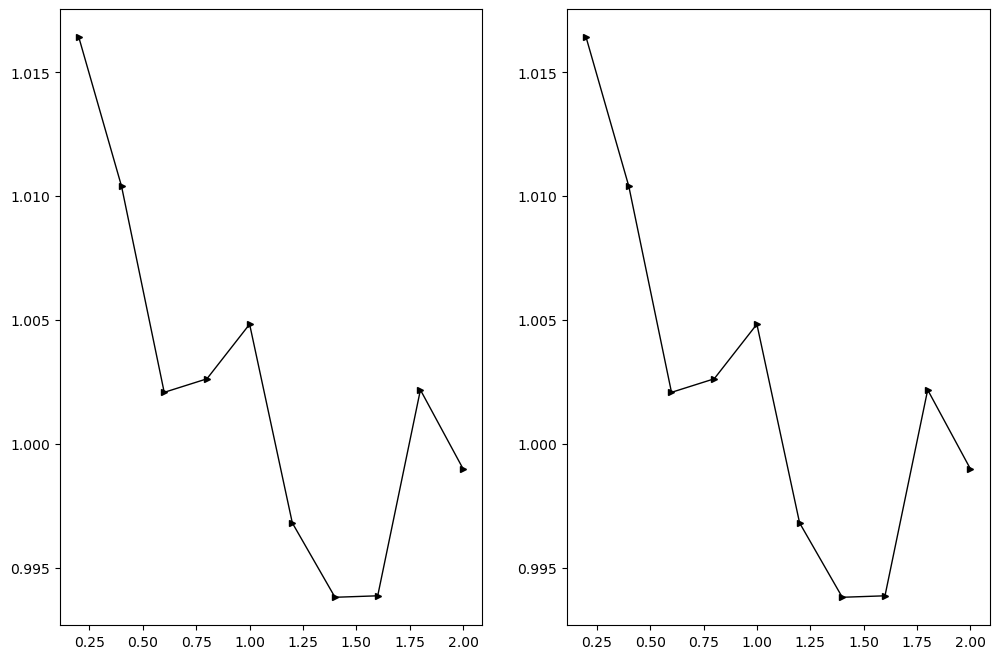

In [69]:
ms = 4
lw = 1

fig,ax = plt.subplots(1,2,figsize=(12, 8))
index = 0 
ax[0].plot(delta_ep_all,rst_mom_avg,'->',color = 'k',markersize=ms,linewidth = lw,label='Forest')
ax[0].plot(delta_ep_all,rst_saa_avg,'->',color = 'k',markersize=ms,linewidth = lw,label='Forest')

        # ax[i,j].set_ylim(1.35,1.95)
# ax[0,0].set_ylabel('CVaR',fontsize = 18)
# ax[1,0].set_ylabel('CVaR',fontsize = 18)

# ax[0,0].set_title(r'Out-of-sample CVaR comparison when $S=63$')
# ax[0,1].set_title(r'Out-of-sample CVaR comparison when $S=126$')
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

# # ax.legend(loc='upper left',fontsize = 18) 
# ax[0,1].legend(loc=2,fontsize = 12, bbox_to_anchor=(1.05,1),borderaxespad = 0.)     ##设置ax4中legend的位置，将其放在图外
# fig_name = 'CVaR (Num of stocks = %(n_x)s,epsilon=%(eps)s)'%{'n_x':n_x,'eps':stochOptForest_params['epsilon'][0]}
# plt.subplots_adjust(wspace =0.2, hspace =0.3)#调整子图间距
# plt.savefig(fig_name+'.pdf', bbox_inches='tight') # 保存成PDF放大后不失真（默认保存在了当前文件夹下）

plt.show()


In [60]:
rst_det_avg

array([ 9679.80626105, 10342.68888164, 10841.70791293, 11198.11682387,
       11631.42340535, 12135.09741742, 12557.01356397, 13077.96663903,
       13265.76661269, 13882.96296635])

In [51]:
rst_saa_avg

array([ 9679.55147392, 10328.49081217, 10820.89169617, 11153.96884232,
       11580.42077273, 12045.20875055, 12461.86110309, 12987.29072144,
       13224.69032951, 13876.40959319])

In [57]:
np.mean(rst_wass_vns[0.8],axis = 0)

array([11153.42591043, 11128.90876298, 10968.73433693, 10828.01027212,
       10730.5931317 , 10668.63305956, 10665.94972725, 10665.94972725,
       10665.94972725, 10665.94972725])

In [59]:
rst_wass_vns_avg[0.8]

0    11153.425910
1    11128.908763
2    10968.734337
3    10828.010272
4    10730.593132
5    10668.633060
6    10665.949727
7    10665.949727
8    10665.949727
9    10665.949727
Name: 0.8, dtype: float64

In [68]:
tft_avg_all.to_csv(project_path + '/data/tft_avg_all.csv')
tft_quan75_all.to_csv(project_path + '/data/tft_quan75_all.csv')
tft_quan95_all.to_csv(project_path + '/data/tft_quan95_all.csv')

# tft_affine_avg_all.to_csv(project_path + '/data/tft_affine_avg_all.csv')
# tft_affine_quan75_all.to_csv(project_path + '/data/tft_affine_quan75_all.csv')
# tft_affine_quan95_all.to_csv(project_path + '/data/tft_affine_quan95_all.csv')

In [69]:
tft_avg_ratio_all = copy.deepcopy(tft_avg_all)
tft_quan75_ratio_all = copy.deepcopy(tft_quan75_all)
tft_quan95_ratio_all = copy.deepcopy(tft_quan95_all)

# tft_affine_avg_ratio_all = copy.deepcopy(tft_affine_avg_all)
# tft_affine_quan75_ratio_all = copy.deepcopy(tft_affine_quan75_all)
# tft_affine_quan95_ratio_all = copy.deepcopy(tft_affine_quan95_all)
for i in range(23):
    tft_avg_ratio_all.iloc[i] = tft_avg_all.iloc[i]/tft_avg_all.iloc[0]
    tft_quan75_ratio_all.iloc[i] = tft_quan75_all.iloc[i]/tft_quan75_all.iloc[0]
    tft_quan95_ratio_all.iloc[i] = tft_quan95_all.iloc[i]/tft_quan95_all.iloc[0]

    # if i < 20:
    #     tft_affine_avg_ratio_all.iloc[i] = tft_affine_avg_all.iloc[i]/tft_avg_all.iloc[0]
    #     tft_affine_quan75_ratio_all.iloc[i] = tft_affine_quan75_all.iloc[i]/tft_quan75_all.iloc[0]
    #     tft_affine_quan95_ratio_all.iloc[i] = tft_affine_quan95_all.iloc[i]/tft_quan95_all.iloc[0]

In [70]:
tft_avg_ratio_all.to_csv(project_path + '/data/tft_avg_ratio_all.csv')
tft_quan75_ratio_all.to_csv(project_path + '/data/tft_quan75_ratio_all.csv')
tft_quan95_ratio_all.to_csv(project_path + '/data/tft_quan95_ratio_all.csv')


# effect of processing mad

In [68]:
project_path = '/Users/zhangxun/Desktop/IJPR/det_release/delta_sigma_p'
n = 10 # num of jobs
delta_mu = 4 # control lb of mean processing time
delta_r = 0.05 # control ub of the release time
delta_ep = 1.5 # control the upper bound of the mad
S_train = 30
S_test = 10000
iterations = 10

In [69]:
Seed = 70
it = 0
ins = 0
full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
tft_df = pd.read_csv(full_path+'tft.csv')


In [4]:
tft_df

,Unnamed: 0,det,saa,mom,wass_489.2535902871846
0,0,1991.243561,1991.243561,2050.341984,2042.934992
1,1,2560.824748,2560.824748,2575.599525,2894.031960
2,2,2317.143569,2317.143569,2283.704315,2431.032977
3,3,2523.811177,2523.811177,2509.779428,2465.802645
4,4,2173.900255,2173.900255,2300.676925,1988.560506
...,...,...,...,...,...
9965,9965,3327.151131,3327.151131,3310.919830,3265.640858
9966,9966,2877.659583,2877.659583,2841.093705,2928.487667
9967,9967,2922.758111,2922.758111,2972.414928,3062.061237
9968,9968,3529.345212,3529.345212,3582.367538,3181.797968


In [7]:
[N_s,N_c] = np.shape(tft_df.values)
tft_df.columns

Index(['Unnamed: 0', 'det', 'saa', 'mom', 'wass_489.2535902871846'], dtype='object')

In [8]:
tft_df.columns.values


array(['Unnamed: 0', 'det', 'saa', 'mom', 'wass_489.2535902871846'],
      dtype=object)

In [70]:
n_all = [10,15,20]
df_final = {}
for n in n_all:
    ins = 0
    Seed = 70 + ins
    delta_ep_all = [1.5,2,2.5]
    for delta_ep in delta_ep_all:
        it = 0
        full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
        with open(full_path+'cpu_time.pkl', "rb") as tf:
            cpu_time = pickle.load(tf)
        print('n=',n,'',cpu_time)

{'det': 0.007964372634887695, 'saa': 0.02291417121887207, 'mom': 0.0949399471282959, 'wass': [2.1790530681610107]}
{'det': 0.001825094223022461, 'saa': 0.0332331657409668, 'mom': 0.025277137756347656, 'wass': [1.3425757884979248]}
{'det': 0.001882791519165039, 'saa': 0.023546218872070312, 'mom': 0.051043033599853516, 'wass': [4.267728805541992]}
{'det': 0.0032062530517578125, 'saa': 0.06666398048400879, 'mom': 1.4807610511779785, 'wass': [16.03339695930481]}
{'det': 0.0032129287719726562, 'saa': 0.06231117248535156, 'mom': 0.5386219024658203, 'wass': [13.839931964874268]}
{'det': 0.0048291683197021484, 'saa': 0.05794715881347656, 'mom': 0.4586060047149658, 'wass': [21.98773694038391]}
{'det': 0.005785226821899414, 'saa': 0.09418582916259766, 'mom': 3.7657229900360107, 'wass': [46.85750699043274]}
{'det': 0.004395008087158203, 'saa': 0.11473417282104492, 'mom': 3.5839810371398926, 'wass': [71.47983884811401]}
{'det': 0.016607046127319336, 'saa': 0.17585468292236328, 'mom': 1.12340688705

In [49]:
n_all = [10,15,20]
df_final = {}
for n in n_all:
    ins = 0
    Seed = 70 + ins
    df_set = {}
    delta_ep_all = [1.5,2,2.5]
    for delta_ep in delta_ep_all:
        it = 0
        full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
        tft_df = pd.read_csv(full_path+'tft.csv')
        df = pd.DataFrame(np.zeros((N_s * 4,3)))
        col_vector = tft_df.columns.values
        col_names = [r'$DET$', r'$SAA$', r'$MM$',r'$DW_{0.5}$']
        col_vector = ['det', 'saa', 'mom',col_vector[4]]
        df.columns = ['tft','appro','delta_ep']
        for i in range(4):
            df['tft'][i*N_s:(i+1)*N_s] = tft_df[col_vector[i]]
            df['appro'][i*N_s:(i+1)*N_s] = np.asarray([col_names[i] for ind in range(N_s)])
            df['delta_ep'][i*N_s:(i+1)*N_s] = np.ones(N_s)*delta_ep
        df_set[delta_ep] = copy.deepcopy(df)
    df_final[n] = pd.concat([df_set[delta_ep] for delta_ep in delta_ep_all])


/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/187074162.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_ep'][i*N_s:(i+1)*N_s] = np.ones(N_s)*delta_ep
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/187074162.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tft'][i*N_s:(i+1)*N_s] = tft_df[col_vector[i]]
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/187074162.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [34]:
df_final[n]

,tft,appro,delta_ep
0,9871.551911,DET,1.5
1,9140.191878,DET,1.5
2,10834.165620,DET,1.5
3,8466.561811,DET,1.5
4,10266.980867,DET,1.5
...,...,...,...
39875,9866.868148,DW\_{0.5},2.5
39876,13979.585098,DW\_{0.5},2.5
39877,9309.673538,DW\_{0.5},2.5
39878,9806.842850,DW\_{0.5},2.5


In [11]:
import seaborn as sns

In [60]:
def plot_group_box(df_final,n_all,fixed_name):
    
    # Plot grouped box plot
    font_size = 20
    tick_size = 16
    line_width = 1
    my_pal = { r'$DET$':"m",r'$MM$':"c",r'$SAA$': "b", r'$DW_{0.5}$': "r"}
    # my_pal = { "Forest":"m","RobustTreeAffine": "r", "RobustStatic": "b"}
    
    num_n = len(n_all)
    fig,ax = plt.subplots(1,num_n,figsize=(12, 8))
    for i in range(num_n):
        graphic = sns.boxplot(x=fixed_name, y='tft',hue = 'appro', data=df_final[n_all[i]],palette=my_pal,\
                                width = 0.75,showmeans = True,meanline = True, \
                                meanprops = {'linestyle':'--','color':'gold','linewidth':line_width},\
                                showfliers = False,\
                                medianprops = {'linestyle':'-','color':'k','linewidth':line_width},
                                linewidth = line_width,ax=ax[i])
        graphic.set_xlabel(r'$\delta_{r}$',fontsize = font_size)
        graphic.xaxis.set_tick_params(labelsize=tick_size)
        if i == 0:
            graphic.set_ylabel('Total completion time',fontsize = font_size+2)
        else:
            graphic.set_ylabel('')
        graphic.yaxis.set_tick_params(labelsize=tick_size)
        graphic.set_title(r'$n=$'+str(n_all[i]),fontsize = font_size+4)
        # graphic.set_yscale('log')
        sns.color_palette('pastel')
        if i == 0:
            graphic.legend([])
        else:
            # graphic.legend(n_cols = 2)
            graphic.legend(loc=7,fontsize = tick_size, bbox_to_anchor=(1.4,0.5),borderaxespad = 0.)
    plt.subplots_adjust(hspace=0.2,wspace=0.3)
    # plt.savefig('impact_mad_r.pdf')
    plt.show()


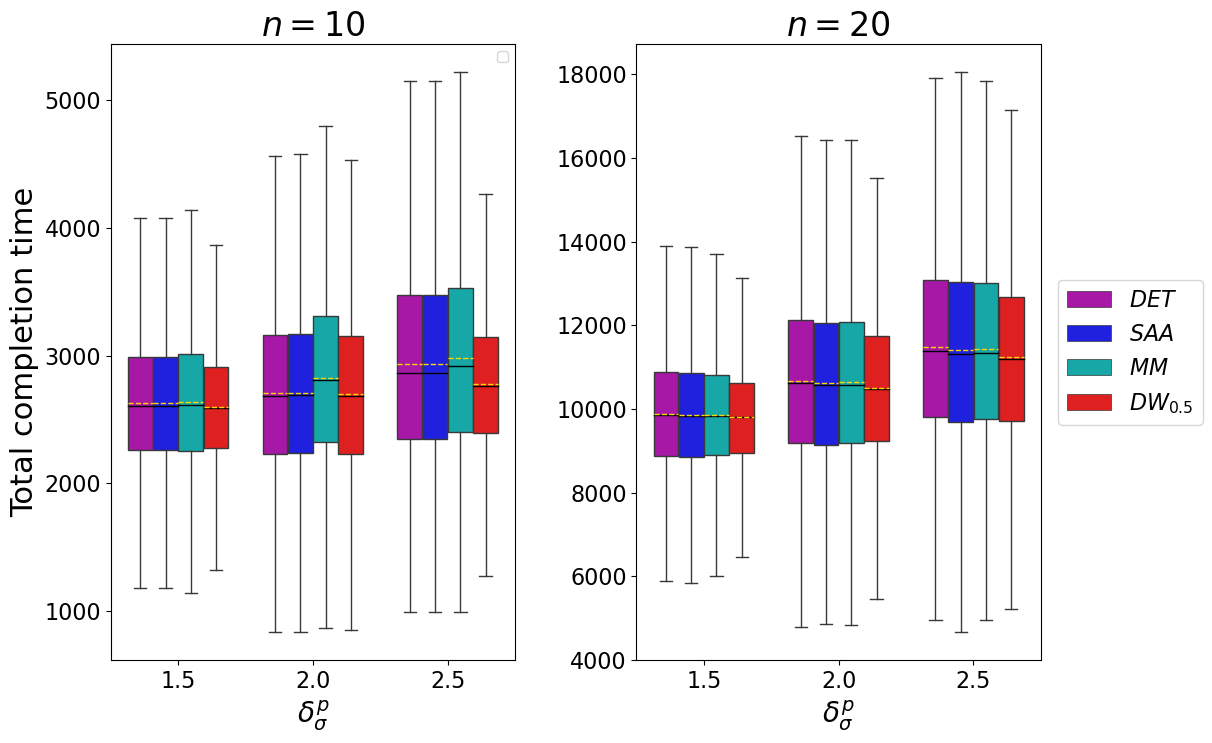

In [52]:
n_all = [10,20]
plot_group_box(df_final,n_all,'delta_ep')

# impact of mad_r

In [53]:
n = 10 # num of jobs
delta_mu = 4 # control lb of mean processing time
delta_r = 0.2 # control ub of the release time
delta_ep = 1.5 # control the upper bound of the mad
S_train = 30
S_test = 10000
iterations = 10


In [54]:
project_path = '/Users/zhangxun/Desktop/IJPR/det_release/sample_size_delta_r'

Seed = 70
it = 0
ins = 0
full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
tft_df = pd.read_csv(full_path+'tft.csv')

In [55]:
tft_df

,Unnamed: 0,det,saa,mom,wass_344.444356059078
0,0,3141.102963,3126.320051,3375.481439,2939.353616
1,1,3220.613292,3215.229479,3129.841991,3078.728909
2,2,2894.630735,2898.450438,2599.639676,2850.377515
3,3,3604.285944,3556.125173,3745.996159,2994.918009
4,4,3298.426104,3260.492132,2975.167515,3080.432138
...,...,...,...,...,...
9965,9965,2195.831867,2203.271820,2454.627698,2591.114558
9966,9966,1815.172935,1849.353031,2250.852555,2345.603396
9967,9967,2014.285512,1963.122164,2331.256438,2795.435185
9968,9968,4248.981188,4229.678009,3771.489519,3176.873745


In [10]:
[N_s,N_c] = np.shape(tft_df.values)

In [58]:
n_all = [10,15,20]
df_final = {}
for n in n_all:
    ins = 0
    Seed = 70 + ins
    df_set = {}
    delta_r_all = [0.05,0.1,0.2]
    for delta_r in delta_r_all:
        it = 0
        full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+'/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep)
        tft_df = pd.read_csv(full_path+'tft.csv')
        df = pd.DataFrame(np.zeros((N_s * 4,3)))
        col_vector = tft_df.columns.values
        col_names = [r'$DET$', r'$SAA$', r'$MM$',r'$DW_{0.5}$']
        col_vector = ['det', 'saa', 'mom',col_vector[4]]
        df.columns = ['tft','appro','delta_r']
        for i in range(4):
            df['tft'][i*N_s:(i+1)*N_s] = tft_df[col_vector[i]]
            df['appro'][i*N_s:(i+1)*N_s] = np.asarray([col_names[i] for ind in range(N_s)])
            df['delta_r'][i*N_s:(i+1)*N_s] = np.ones(N_s)*delta_r
        df_set[delta_r] = copy.deepcopy(df)
    df_final[n] = pd.concat([df_set[delta_r] for delta_r in delta_r_all])

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/2416611074.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_r'][i*N_s:(i+1)*N_s] = np.ones(N_s)*delta_r
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/2416611074.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tft'][i*N_s:(i+1)*N_s] = tft_df[col_vector[i]]
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_49670/2416611074.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [16]:
df_final[n]

,tft,appro,delta_r
0,8647.279102,DET,0.05
1,7189.652661,DET,0.05
2,9751.720727,DET,0.05
3,11282.156715,DET,0.05
4,11309.365152,DET,0.05
...,...,...,...
39875,10396.872388,W=0.5,0.20
39876,9792.959015,W=0.5,0.20
39877,11803.745543,W=0.5,0.20
39878,10811.101199,W=0.5,0.20


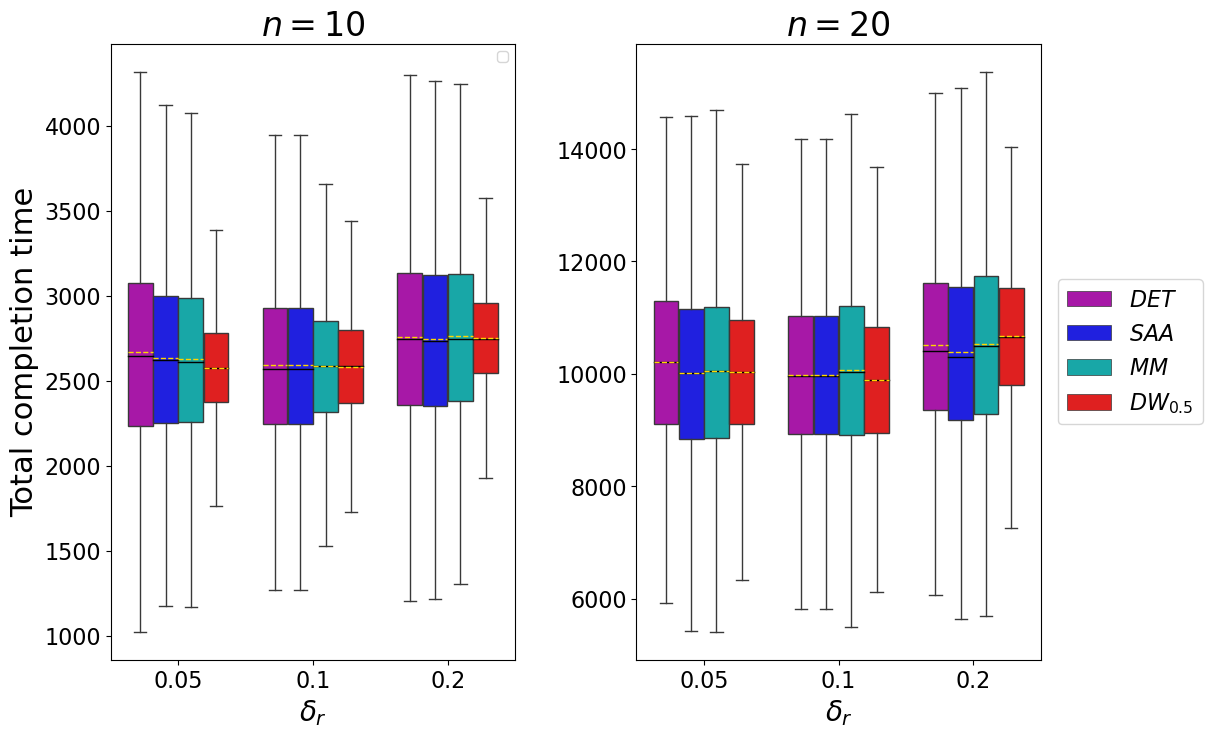

In [61]:
n_all = [10,20]
plot_group_box(df_final,n_all,'delta_r')

# cpu time

In [25]:
project_path = '/Users/zhangxun/Desktop/IJPR/random_release/rand/rand_cpu_time'
n = 10 # num of jobs
delta_mu = 4 # control lb of mean processing time
delta_r = 0.05 # control ub of the release time
delta_ep = 1.5 # control the upper bound of the mad
S_train = 30
S_test = 10000
iterations = 10
Seed = 0

In [30]:
ins = 0
it = 0
full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+\
    '/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep) + 'delta_mad_r=0.3'


In [36]:
full_path
with open(full_path+'cpu_time.pkl', "rb") as tf:
    cpu_time = pickle.load(tf)

In [37]:
cpu_time

array([0.00160289, 0.07864404, 0.15371227])

In [39]:
n_all = [10,15,20,25,30]
time_arr = np.zeros((5,3))
i = 0
for n in n_all:
    
    ins = 0
    Seed =ins
    df_set = {}
    delta_r_all = [0.05,0.1,0.2]
    
    it = 0
    full_path = project_path + '/data/seed='+str(Seed)+'/ins='+str(ins) + '/it='+str(it)+'/S_train='+str(S_train)+\
    '/n='+str(n)+'delta_mu='+str(delta_mu)+'delta_r='+str(delta_r)+'delta_ep='+str(delta_ep) + 'delta_mad_r=0.3'
    with open(full_path+'cpu_time.pkl', "rb") as tf:
        cpu_time = pickle.load(tf)
    print(cpu_time)
    time_arr[i,:] = cpu_time
    # appro = ['det','saa','wass']


    # for j in range(len(appro)):
    #     if j != 3:
    #         time_arr[i,j] = cpu_time[appro[j]]
    #     else:
    #         time_arr[i,j] = cpu_time[appro[j]][0]
    i = i + 1

[0.00160289 0.07864404 0.15371227]
[0.00353503 0.07788062 0.34568119]
[0.00419807 0.20426106 0.89547706]
[0.00670815 1.12704992 1.66856694]
[0.01013279 1.47761488 2.65237403]


In [23]:
pd.DataFrame(time_arr).to_csv(project_path + '/data/cpu.csv')